In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm 
from xgboost import XGBRegressor
import shap 








In [73]:
df = pd.read_csv("https://raw.githubusercontent.com/marcel0501/Wine/refs/heads/main/WineQT.csv")
df.describe()
Dep_var = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
X = df[Dep_var]
y = df["quality"]




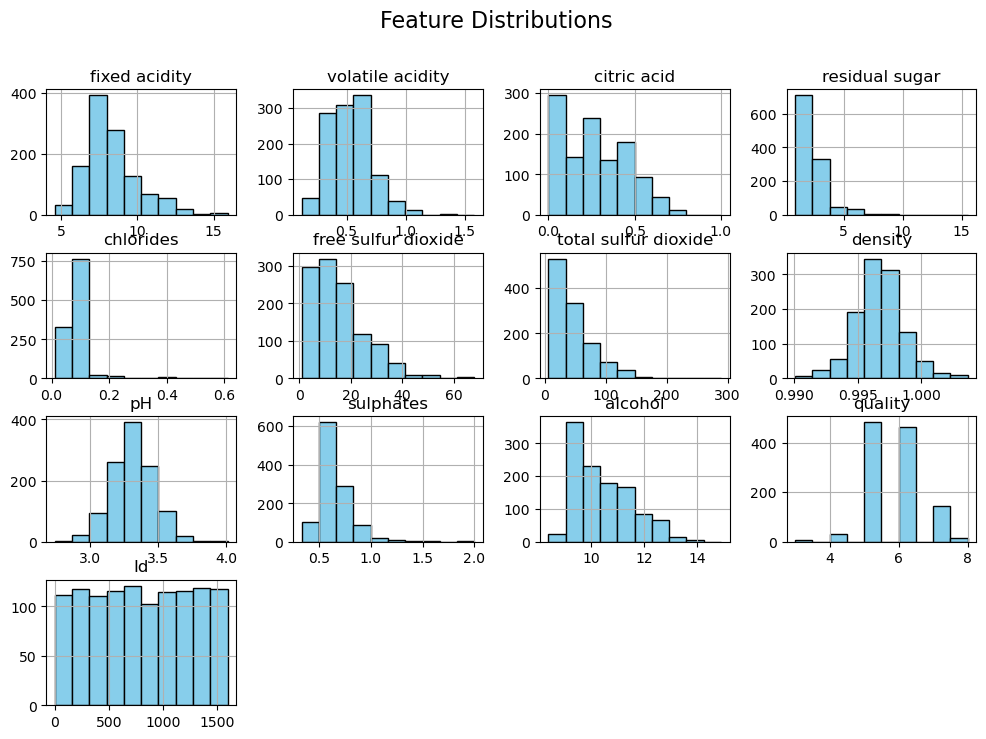

In [74]:
df.hist(figsize=(12, 8),bins = 10, color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

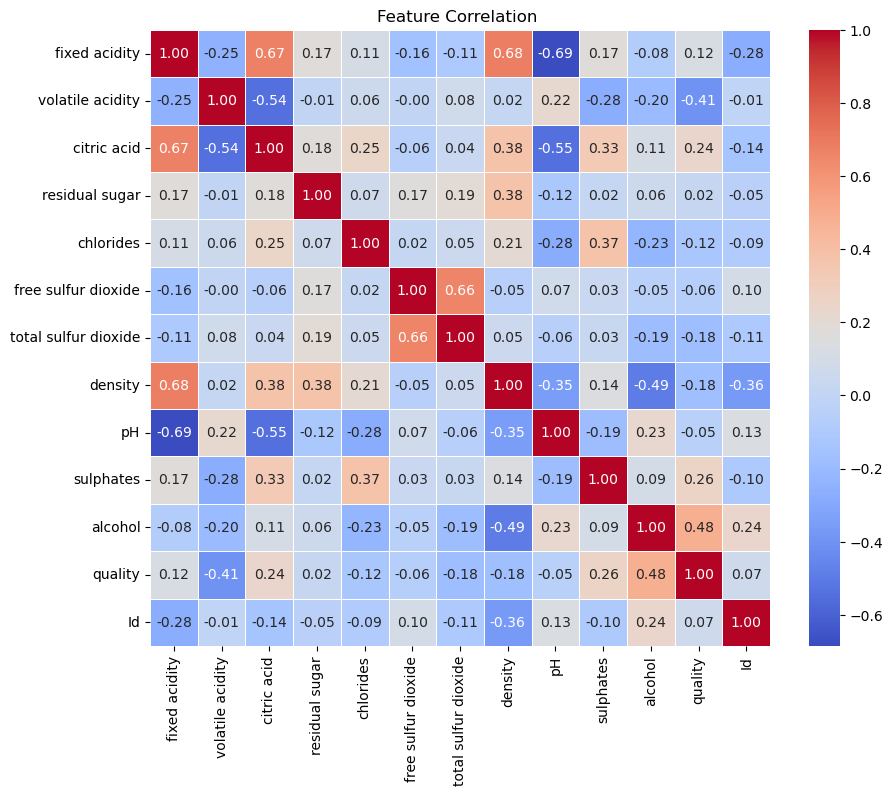

In [75]:
#Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation ")
plt.show()

In [76]:
#Group wine in classes Low: 3/5 Med: 6, High:7/10
y = df['quality']
#3rd class imbalanced -> use of SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X,y)


In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_resampled,test_size=0.2,random_state=42)

In [79]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)
y_pred_lr = lr_model.predict(X_test)
print("Linear Regression:", r2_score(y_test, y_pred_lr))

X_train_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

Linear Regression: 0.7326463112981659
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     573.2
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:57:40   Log-Likelihood:                -3009.0
No. Observations:                2318   AIC:                             6042.
Df Residuals:                    2306   BIC:                             6111.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

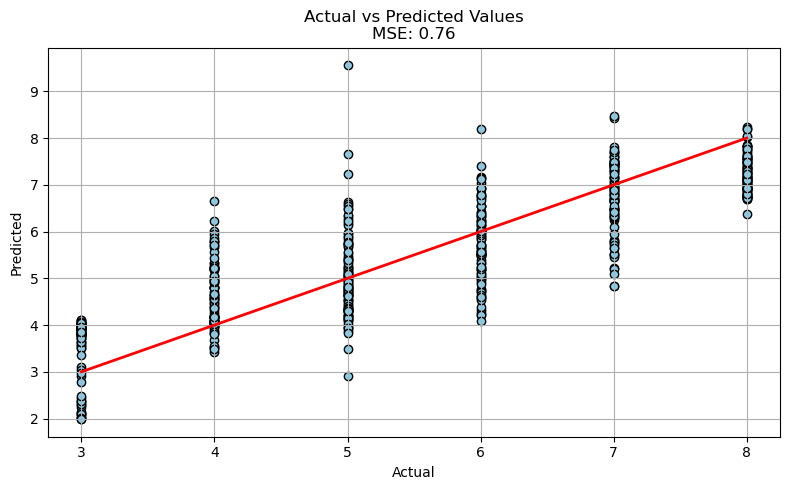

In [80]:
mse = mean_squared_error(y_test, y_pred_lr)
plt.figure(figsize=(8,5))
plt.scatter(y_test,y_pred_lr,color="skyblue",edgecolors="black")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title(f'Actual vs Predicted Values\nMSE: {mse:.2f}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

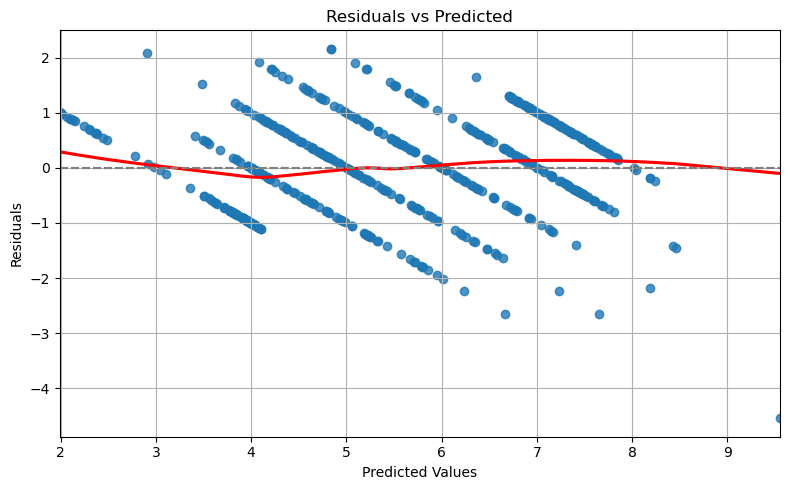

In [81]:
residuals = y_test - y_pred_lr

# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=y_pred_lr, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
#Let's try using some non linear models.

In [ ]:
param_grid = {
    'n_estimators': [50, 500, 1000],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2', 0.7,0.8]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
#Using the best parameters from the grid search
best_params = grid_search.best_params_
RFreg = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                              max_depth=best_params['max_depth'],
                              min_samples_split=best_params['min_samples_split'],
                              max_features=best_params['max_features'], random_state=42)
RFreg.fit(X_train, y_train)
y_pred_RF = RFreg.predict(X_test)
y_pred_RF_train = RFreg.predict(X_train)
print("Random Forest Regression:", r2_score(y_test, y_pred_RF))
print("Random Forest Regression Train:", r2_score(y_train, y_pred_RF_train))


#Using the default parameters for Random Forest Regressor
RFreg = RandomForestRegressor(n_estimators=5,
                              max_depth=10,
                              min_samples_split=2,
                              max_features='sqrt', random_state=42)
RFreg.fit(X_train, y_train)
y_pred_RF = RFreg.predict(X_test)
y_pred_RF_train = RFreg.predict(X_train)


print("Random Forest Regression:", r2_score(y_test, y_pred_RF))
print("Random Forest Regression Train:", r2_score(y_train, y_pred_RF_train))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 1000}
Best cross-validation score:  0.9308141641965889
Random Forest Regression: 0.9402758221209901
Random Forest Regression Train: 0.9917002693469513
Random Forest Regression: 0.9186243952373175
Random Forest Regression Train: 0.9592420986401092


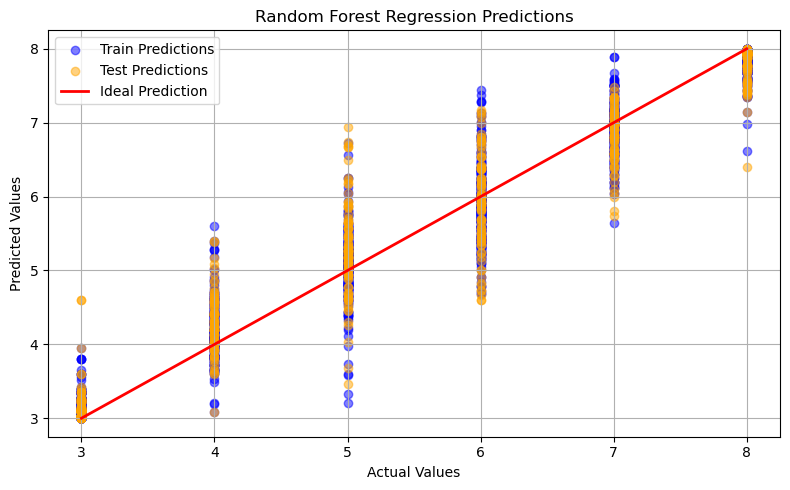

In [84]:
#Let's check if the model is overfitting
plt.figure(figsize=(8, 5))
plt.scatter(y_train, y_pred_RF_train, color='blue', label='Train Predictions', alpha=0.5)
plt.scatter(y_test, y_pred_RF, color='orange', label='Test Predictions', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label='Ideal Prediction')
plt.title('Random Forest Regression Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:
# Perform 10-fold cross-validation 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = model_selection.cross_val_score(RFreg, X_scaled, y_resampled, scoring='r2', cv=cv, n_jobs=-1)
print("Cross-Validation R^2 Scores:", scores)
print("Mean Cross-Validation R^2 Score:", np.mean(scores))
print(f"Standard deviation of cross-validation scores: {np.std(scores)}")



Cross-Validation R^2 Scores: [0.91156611 0.91462266 0.90305003 0.90987243 0.92391435 0.89185196
 0.90773189 0.8579991  0.91231419 0.92528036 0.9218092  0.8990458
 0.88607514 0.88852268 0.90585329 0.90119611 0.89099119 0.89873392
 0.90314745 0.89453119 0.89118814 0.91682187 0.9054274  0.87927661
 0.87487894 0.91120984 0.9016755  0.92272432 0.92641475 0.91339607]
Mean Cross-Validation R^2 Score: 0.9030374163570639
Standard deviation of cross-validation scores: 0.015666929590024983


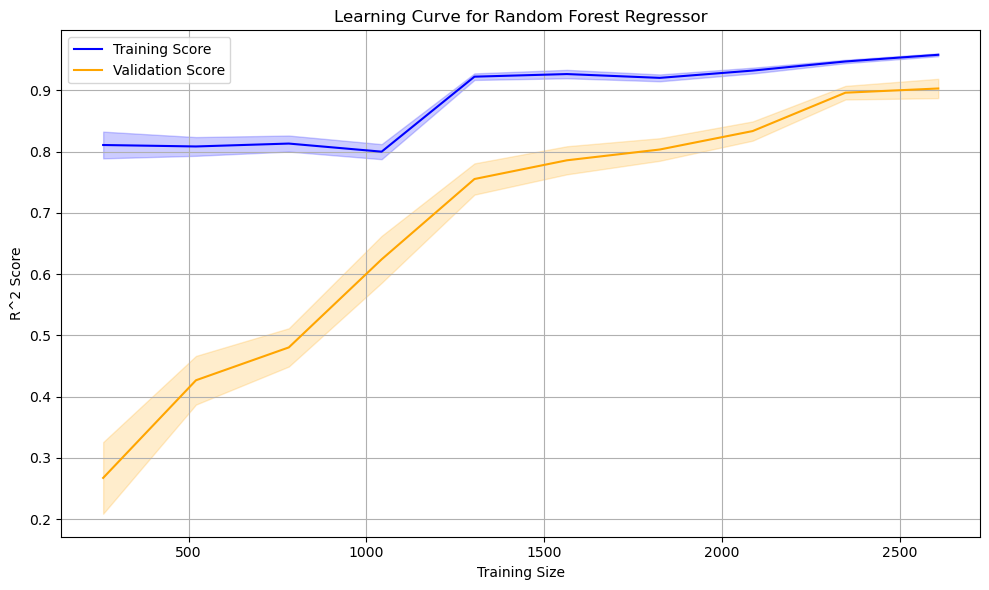

In [ ]:
train_sizes, train_scores, val_scores = model_selection.learning_curve(RFreg, X_scaled, y_resampled, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1) 
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.plot(train_sizes, val_mean, label='Validation Score', color='orange')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)
plt.title('Learning Curve for Random Forest Regressor')
plt.xlabel('Training Size')
plt.ylabel('R^2 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('learning_curve.png', dpi=300)

In [100]:
#Let's try using XGBoost with the default parameters
XGBReg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

# Fit to your training data
XGBReg.fit(X_train, y_train)

# Predict on new data
predictions = XGBReg.predict(X_test)

#Let`s check the accuracy of the data 
print("XGBoost Regression Test:", r2_score(y_test, predictions))
print("XGBoost Regression Train:", r2_score(y_train, XGBReg.predict(X_train)))  
#Using the best parameters from the grid search

param_grid = {
    'n_estimators': [1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5 , 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    "reg_lambda": [1],
    "reg_alpha": [0.1],
}

modelXGB = XGBRegressor()
# Perform grid search with cross-validation
grid_search = GridSearchCV(modelXGB, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

y_pred_XGB = grid_search.predict(X_test)
y_pred_XGB_train = grid_search.predict(X_train)

#Let's check the accuracy of the data

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
print("XGB Test R2 accuracy", r2_score(y_test, y_pred_XGB))
print("XGB Train: R2 accuracy", r2_score(y_train, y_pred_XGB_train))



XGBoost Regression Test: 0.8802468776702881
XGBoost Regression Train: 0.9106357097625732
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
Best cross-validation score:  0.9330915451049805
XGB Test R2 accuracy 0.9432629346847534
XGB Train: R2 accuracy 0.9962567090988159


In [101]:
#Checking for Overfitting with Cross Validation Method


cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = model_selection.cross_val_score(grid_search.best_estimator_, X_scaled, y_resampled, scoring='r2', cv=cv, n_jobs=-1)
print("Cross-Validation R^2 Scores:", scores)
print("Mean Cross-Validation R^2 Score:", np.mean(scores))
print(f"Standard deviation of cross-validation scores: {np.std(scores)}")

Cross-Validation R^2 Scores: [0.9502266  0.94563693 0.93914676 0.9438293  0.95030904 0.93910027
 0.94777328 0.91564417 0.95643741 0.94891739 0.95210493 0.94286865
 0.94073284 0.92971826 0.94355321 0.94618666 0.95108819 0.94079632
 0.94645953 0.94398671 0.94157648 0.94602811 0.94118881 0.94099641
 0.93210441 0.95657605 0.94029659 0.94911426 0.95907712 0.94771588]
Mean Cross-Validation R^2 Score: 0.944306351741155
Standard deviation of cross-validation scores: 0.008334486649882494


In [ ]:
train_sizes_XGB, train_scores_XGB, val_scores_XGB = model_selection.learning_curve(grid_search, X_scaled, y_resampled, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='r2')
XGB_train_scores_mean = np.mean(train_scores_XGB, axis=1)
XGB_train_scores_std = np.std(train_scores_XGB, axis=1) 
XGB_val_mean = np.mean(val_scores_XGB, axis=1)
XGB_val_std = np.std(val_scores_XGB, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_XGB, XGB_train_scores_mean, label='Training Score', color='blue')
plt.plot(train_sizes_XGB, val_mean, label='Validation Score', color='orange')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)
plt.title('Learning Curve for Random Forest Regressor')
plt.xlabel('Training Size')
plt.ylabel('R^2 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('learning_curve.png', dpi=300)

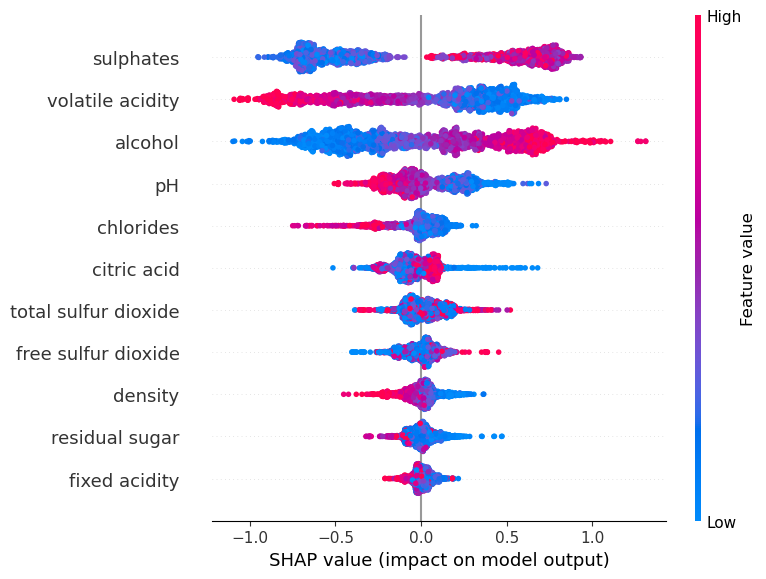

In [102]:
X_scaled_df = pd.DataFrame(X_scaled, columns=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'])


explainer = shap.Explainer(grid_search.best_estimator_)
shap_values = explainer(X_scaled_df)  # X_scaled is your input data

# Summary plot
shap.summary_plot(shap_values, X_scaled_df)